# Introduction

The goal of this project is to classify ECG heat beats using convolutional neural networks (CNN's).

Data Source: 
    - MIT-BIH: The Massachusetts Institute of Technology – Beth Israel Hospital Arrhythmia Database
        - 48 records of 30 min each
        - Download from PhysioNet (https://physionet.org/physiobank/database/#ecg)

Heart beat - the fiducial points:


Types of beats to be classified: 



Plan of procedure: 


### 1) Using CNN on input:  Rpeak -19 / +20  ticks  (QRS only, both channels)

In [1]:
import os, sys
sys.path.append("./module")
import cnn_ecg as cnn_v1

##### Load up Dataset #1 (Classification) and Dataset #2 (Evaluation)  and create beat segments using inputs

In [2]:
# Set the length of the beat segment -> 40 ticks, appr. 1 QRS-interval
preX = 19
postX = 20
# Load DS1 - train and DS2 - eval datasets
ds1_all, ds1_ann, ds1_seg, ds1_lab = cnn_v1.create_DS("1",preX,postX)
ds2_all, ds2_ann, ds2_seg, ds2_lab = cnn_v1.create_DS("2",preX,postX)


##### Examples of beats obtained from MIT-BIH dataset

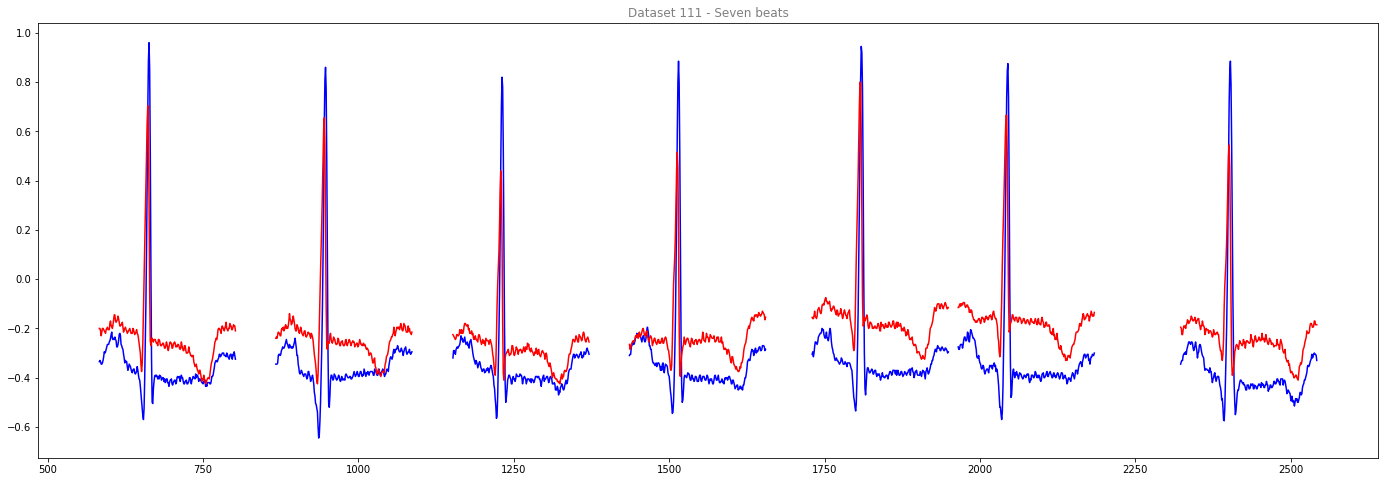

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

preX = 79;
postX = 140;
begNList = [];
endNList = [];
mixNList = [];
sliceNList = [];
    
for index, row in ds2_ann["100"].iterrows():
    Nbegin = row['sample'] - preX;
    Nend = row['sample'] + postX;
    begNList.append(Nbegin);
    endNList.append(Nend);

mixNList = tuple(zip(begNList,endNList)) 
#mixNList[-1]
        
plt.figure(figsize=(24,8))

for x in range(0,7):
    dfseg1 = ds2_all["100"][(ds2_all["100"]['sample'] >= mixNList[x][0]) & (ds2_all["100"]['sample'] <= mixNList[x][1])]
    plt.title('Dataset 111 - Seven beats', color="grey")
    plt.plot(dfseg1['MLII'], color="blue")
    plt.plot(dfseg1['V5'], color="red")

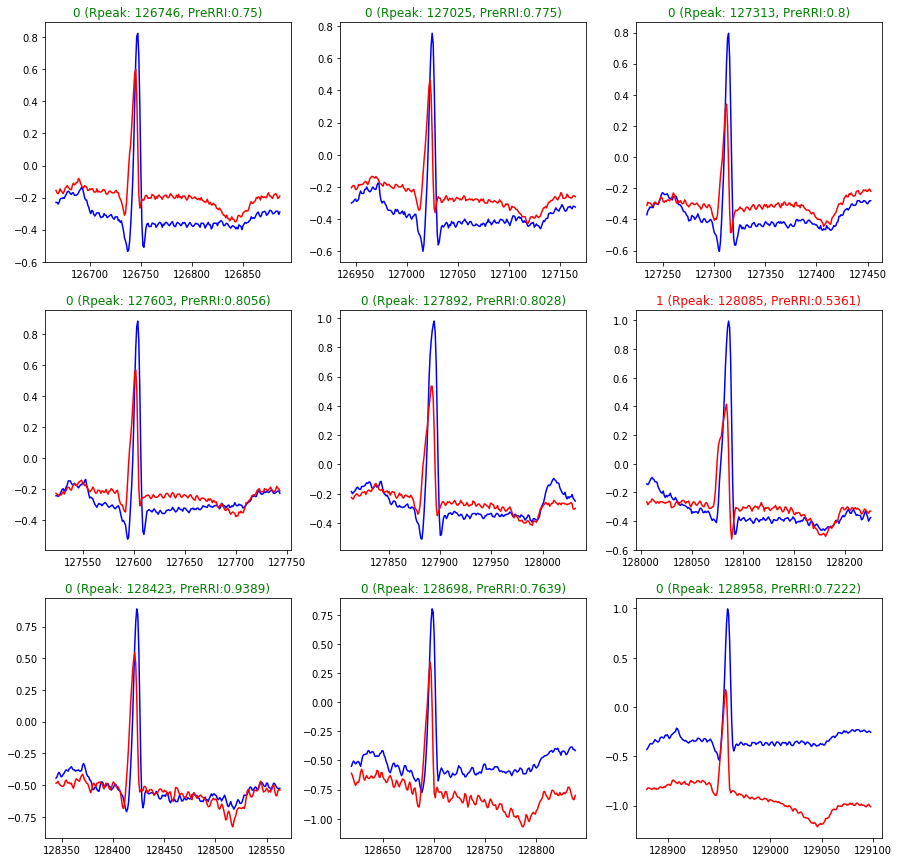

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(nrows=3, ncols=3, figsize = (15,15))

i = 434 # 20 115        
y = -1
for x in range(0,9):
    if x % 3 == 0:
        y=y+1
    dfseg1 = ds2_all["100"][(ds2_all["100"]['sample'] >= mixNList[x+i][0]) & (ds2_all["100"]['sample'] <= mixNList[x+i][1])]
    
    if str(ds2_ann["100"]['Type'][x+i+1]) != '0':
        axes[y, x % 3].set_title('my title', color="red")
    else:
        axes[y, x % 3].set_title('my title', color="green")
  
    axes[y, x % 3].plot(dfseg1['MLII'], color="blue")
    axes[y, x % 3].plot(dfseg1['V5'], color="red")
    axes[y, x % 3].set_title(str(ds2_ann["100"]['Type'][x+i+1]) + ' (Rpeak: ' + str(ds2_ann["100"]['sample'][x+i+1])  + ', PreRRI:' + str(float("{0:.4f}".format(ds2_ann["100"]['RRI'][x+i+1]))) +  ')' )


##### Create the training and evaluation data and labels

In [10]:
import numpy as np

# Prepare the input vectors as numpy arrays
train_data = ds1_seg
train_labels = np.asarray(ds1_lab, dtype=np.int32)
eval_data = ds2_seg
eval_labels = np.array(ds2_lab, dtype=np.int32)

# The total counts for all classes:
# Beat types:
# 0 - Normal beat  (N)
# 1 - Premature ventricular contraction (V)
# 2 - Atrial premature beat (SVEB)
# 3 - Fusion of ventricular and normal beat (F)
# 4 - Unclassifiable beat (Q)
print(np.unique(train_labels, return_counts=True))
print(np.unique(eval_labels, return_counts=True))



(array([0, 1, 2, 3, 4], dtype=int32), array([46077,   944,  4008,   414,   267]))
(array([0, 1, 2, 3, 4], dtype=int32), array([44486,  1837,  3225,   388,   745]))


##### Graph of convolutional network model used

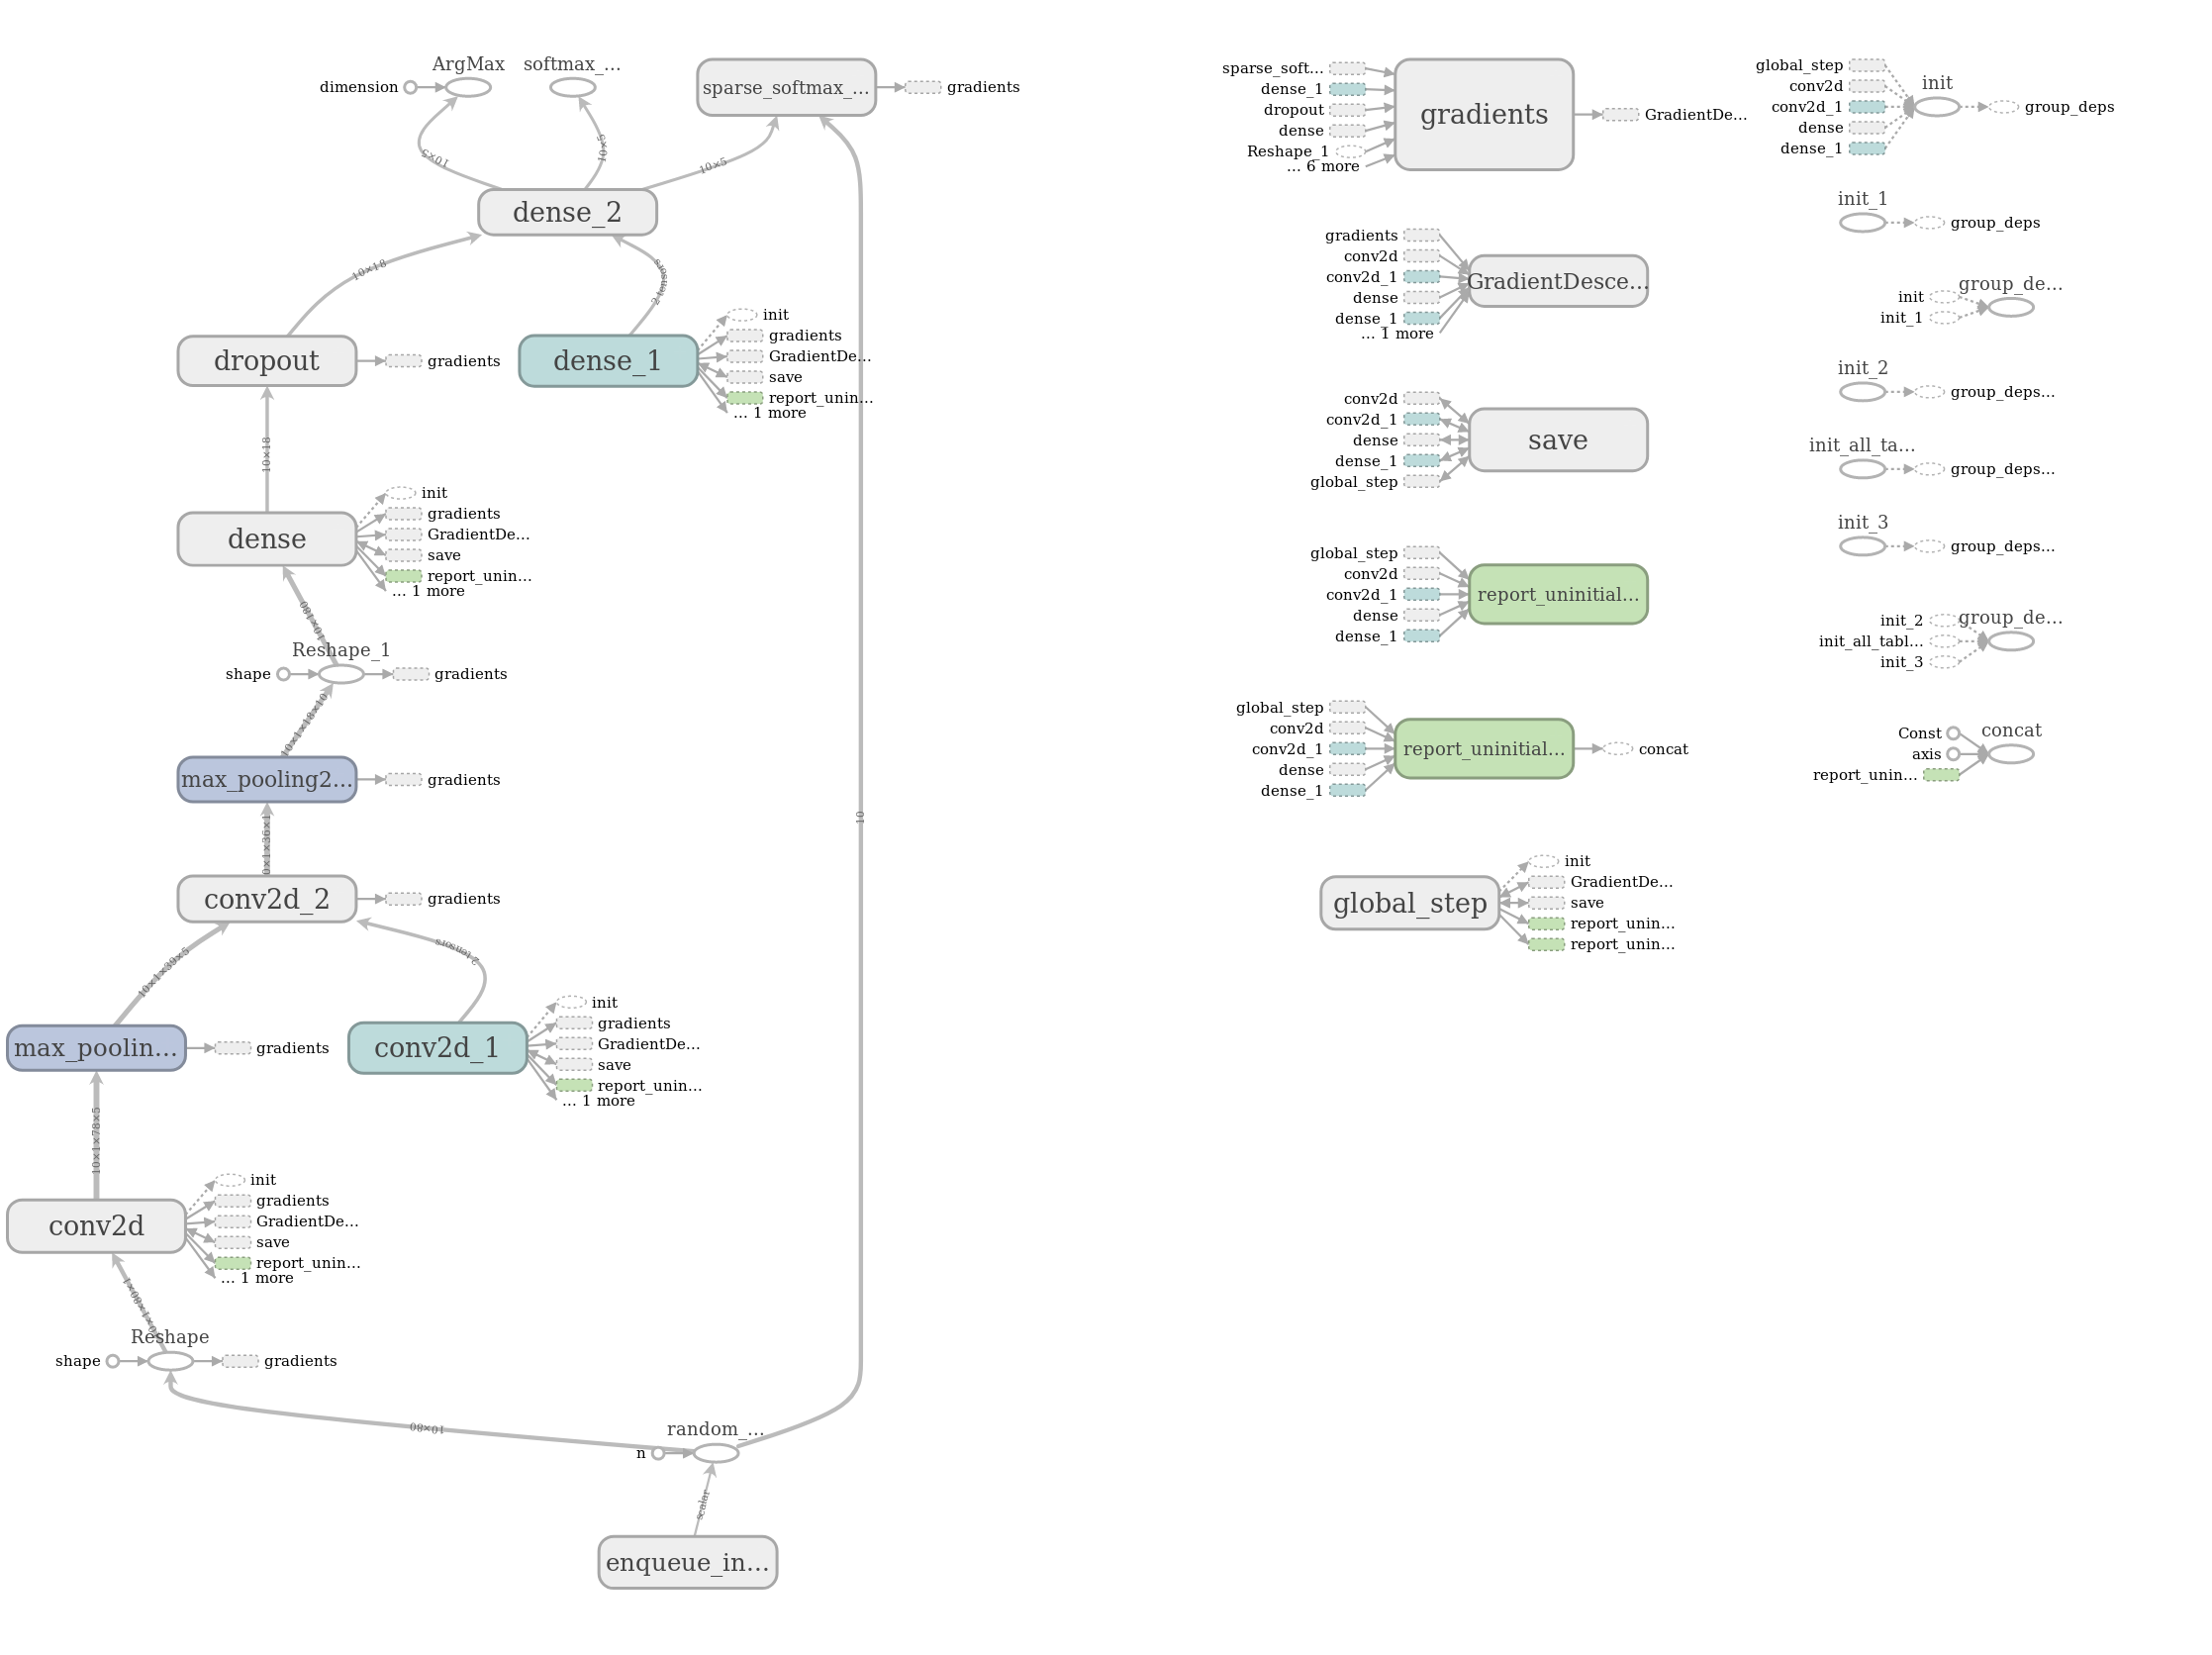

In [7]:
from IPython.display import Image
Image("img/cnn_v1.png")

##### Set up classifier and run the training of the network

In [8]:
import tensorflow as tf

ecg_classifier = tf.estimator.Estimator(model_fn=cnn_v1.cnn_model_fn, model_dir="/tmp/ecg_convnet_model")
    
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)
    
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=10,
    num_epochs=None,
    shuffle=True)
ecg_classifier.train(
    input_fn=train_input_fn,
    steps=2000,
    hooks=[logging_hook])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/ecg_convnet_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5b86db58d0>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/ecg_convnet_model/model.ckpt-6000
INFO:tensorflow:Saving checkpoints for 6001 into /tmp/ecg_convnet_model/model.ckpt.
INFO:tensorflow:probabilities = [[0.99996924 0.00001423 0.00001447 0.00000005 0.00000203]
 [0.9988864  0.00003111 0.00099025 0.00000582 0.00008642]
 [0.99865085 0.00003174 0.00124125 0.00000276 0.00007348]


INFO:tensorflow:probabilities = [[0.9077969  0.04556301 0.01356151 0.01722059 0.01585805]
 [0.00716249 0.00418061 0.8579408  0.11823872 0.01247735]
 [0.93009627 0.04100176 0.00995795 0.01374663 0.00519744]
 [0.9727682  0.01927892 0.00252998 0.00293289 0.00249008]
 [0.9647727  0.02444187 0.00339558 0.00218544 0.00520444]
 [0.95869124 0.02787948 0.00814953 0.00072654 0.00455324]
 [0.83159393 0.05673796 0.04268933 0.0261145  0.04286421]
 [0.96790385 0.02463323 0.00343087 0.00113462 0.00289737]
 [0.929992   0.02930113 0.0219121  0.00287174 0.01592299]
 [0.47540626 0.02962281 0.4350063  0.03635769 0.02360692]] (0.062 sec)
INFO:tensorflow:global_step/sec: 820.45
INFO:tensorflow:probabilities = [[0.8640905  0.0525299  0.03970919 0.02620542 0.01746496]
 [0.98938423 0.00765042 0.00200329 0.00028405 0.00067803]
 [0.89499485 0.04110748 0.03310944 0.01810176 0.01268645]
 [0.94512606 0.0250224  0.01247764 0.01403753 0.00333639]
 [0.9671902  0.02471023 0.00342035 0.00026487 0.00441437]
 [0.9259418  

INFO:tensorflow:global_step/sec: 845.829
INFO:tensorflow:probabilities = [[0.9930316  0.00606829 0.00065077 0.00009941 0.00015003]
 [0.42200553 0.17575759 0.18562846 0.10314649 0.113462  ]
 [0.9437823  0.02048456 0.03353824 0.00087376 0.00132107]
 [0.95244056 0.02778414 0.01555722 0.00083635 0.00338166]
 [0.87122256 0.03360199 0.07789248 0.01000338 0.00727961]
 [0.8831106  0.05503111 0.03469969 0.01923819 0.00792045]
 [0.8817772  0.00108078 0.11560997 0.00148479 0.00004718]
 [0.84437966 0.03213904 0.10882138 0.00223385 0.01242613]
 [0.9648332  0.01021564 0.02217591 0.00156068 0.00121463]
 [0.2581856  0.09516292 0.570034   0.01744508 0.05917238]] (0.059 sec)
INFO:tensorflow:loss = 0.56658703, step = 7201 (0.118 sec)
INFO:tensorflow:probabilities = [[0.94191664 0.03779254 0.01593911 0.00030645 0.00404518]
 [0.8329619  0.06887597 0.04116856 0.00872434 0.04826921]
 [0.8927201  0.02937603 0.06277189 0.00399008 0.01114178]
 [0.8533408  0.06785423 0.04946351 0.01067912 0.01866226]
 [0.9860563

INFO:tensorflow:loss = 0.20500699, step = 7801 (0.127 sec)
INFO:tensorflow:probabilities = [[0.99064493 0.0053907  0.00248657 0.00023628 0.00124157]
 [0.9883767  0.00918697 0.00067336 0.00002491 0.00173797]
 [0.9989968  0.00087    0.00005987 0.00002257 0.00005074]
 [0.7766827  0.03663942 0.14324269 0.00416684 0.03926843]
 [0.36037627 0.14640537 0.39254397 0.00806906 0.09260534]
 [0.00001499 0.00012399 0.9997392  0.00000051 0.00012122]
 [0.99684083 0.00118757 0.00070681 0.00074257 0.00052214]
 [0.93006325 0.00972834 0.02282936 0.03059868 0.00678038]
 [0.9997253  0.00013759 0.00007666 0.00004208 0.00001834]
 [0.98540986 0.00602012 0.00532133 0.00115241 0.00209629]] (0.078 sec)
INFO:tensorflow:global_step/sec: 662.579
INFO:tensorflow:probabilities = [[0.16575088 0.01577112 0.7866899  0.00835508 0.02343302]
 [0.999699   0.00018369 0.00003984 0.00000643 0.00007111]
 [0.1497735  0.03098406 0.69551146 0.05821515 0.06551585]
 [0.13702127 0.02103643 0.7946625  0.01388746 0.03339239]
 [0.9997398

##### Run evaluation of the model

In [9]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=20,
    shuffle=False)
eval_results = ecg_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)
 

INFO:tensorflow:Starting evaluation at 2018-04-11-16:28:41
INFO:tensorflow:Restoring parameters from /tmp/ecg_convnet_model/model.ckpt-8000
INFO:tensorflow:Finished evaluation at 2018-04-11-16:28:55
INFO:tensorflow:Saving dict for global step 8000: accuracy = 0.90031767, global_step = 8000, loss = 0.41557667
{'accuracy': 0.90031767, 'loss': 0.41557667, 'global_step': 8000}


##### Result

In [ ]:
{'accuracy': 0.8783765, 'loss': 0.72681844, 'global_step': 6000}

### 2) Using CNN on input:  Rpeak -89 / +150  ticks  (appr. entire PQRST, both channels)

In [4]:

# Set the length of the beat segment -> 40 ticks, appr. 1 QRS-interval
preX = 89
postX = 150
# Load DS1 - train and DS2 - eval datasets
ds1_all, ds1_ann, ds1_seg, ds1_lab = cnn_v1.create_DS("1",preX,postX)
ds2_all, ds2_ann, ds2_seg, ds2_lab = cnn_v1.create_DS("2",preX,postX)

In [13]:
import numpy as np

# Prepare the input vectors as numpy arrays
train_data = ds1_seg
train_labels = np.asarray(ds1_lab, dtype=np.int32)
eval_data = ds2_seg
eval_labels = np.array(ds2_lab, dtype=np.int32)


##### Graph of convolutional network model used

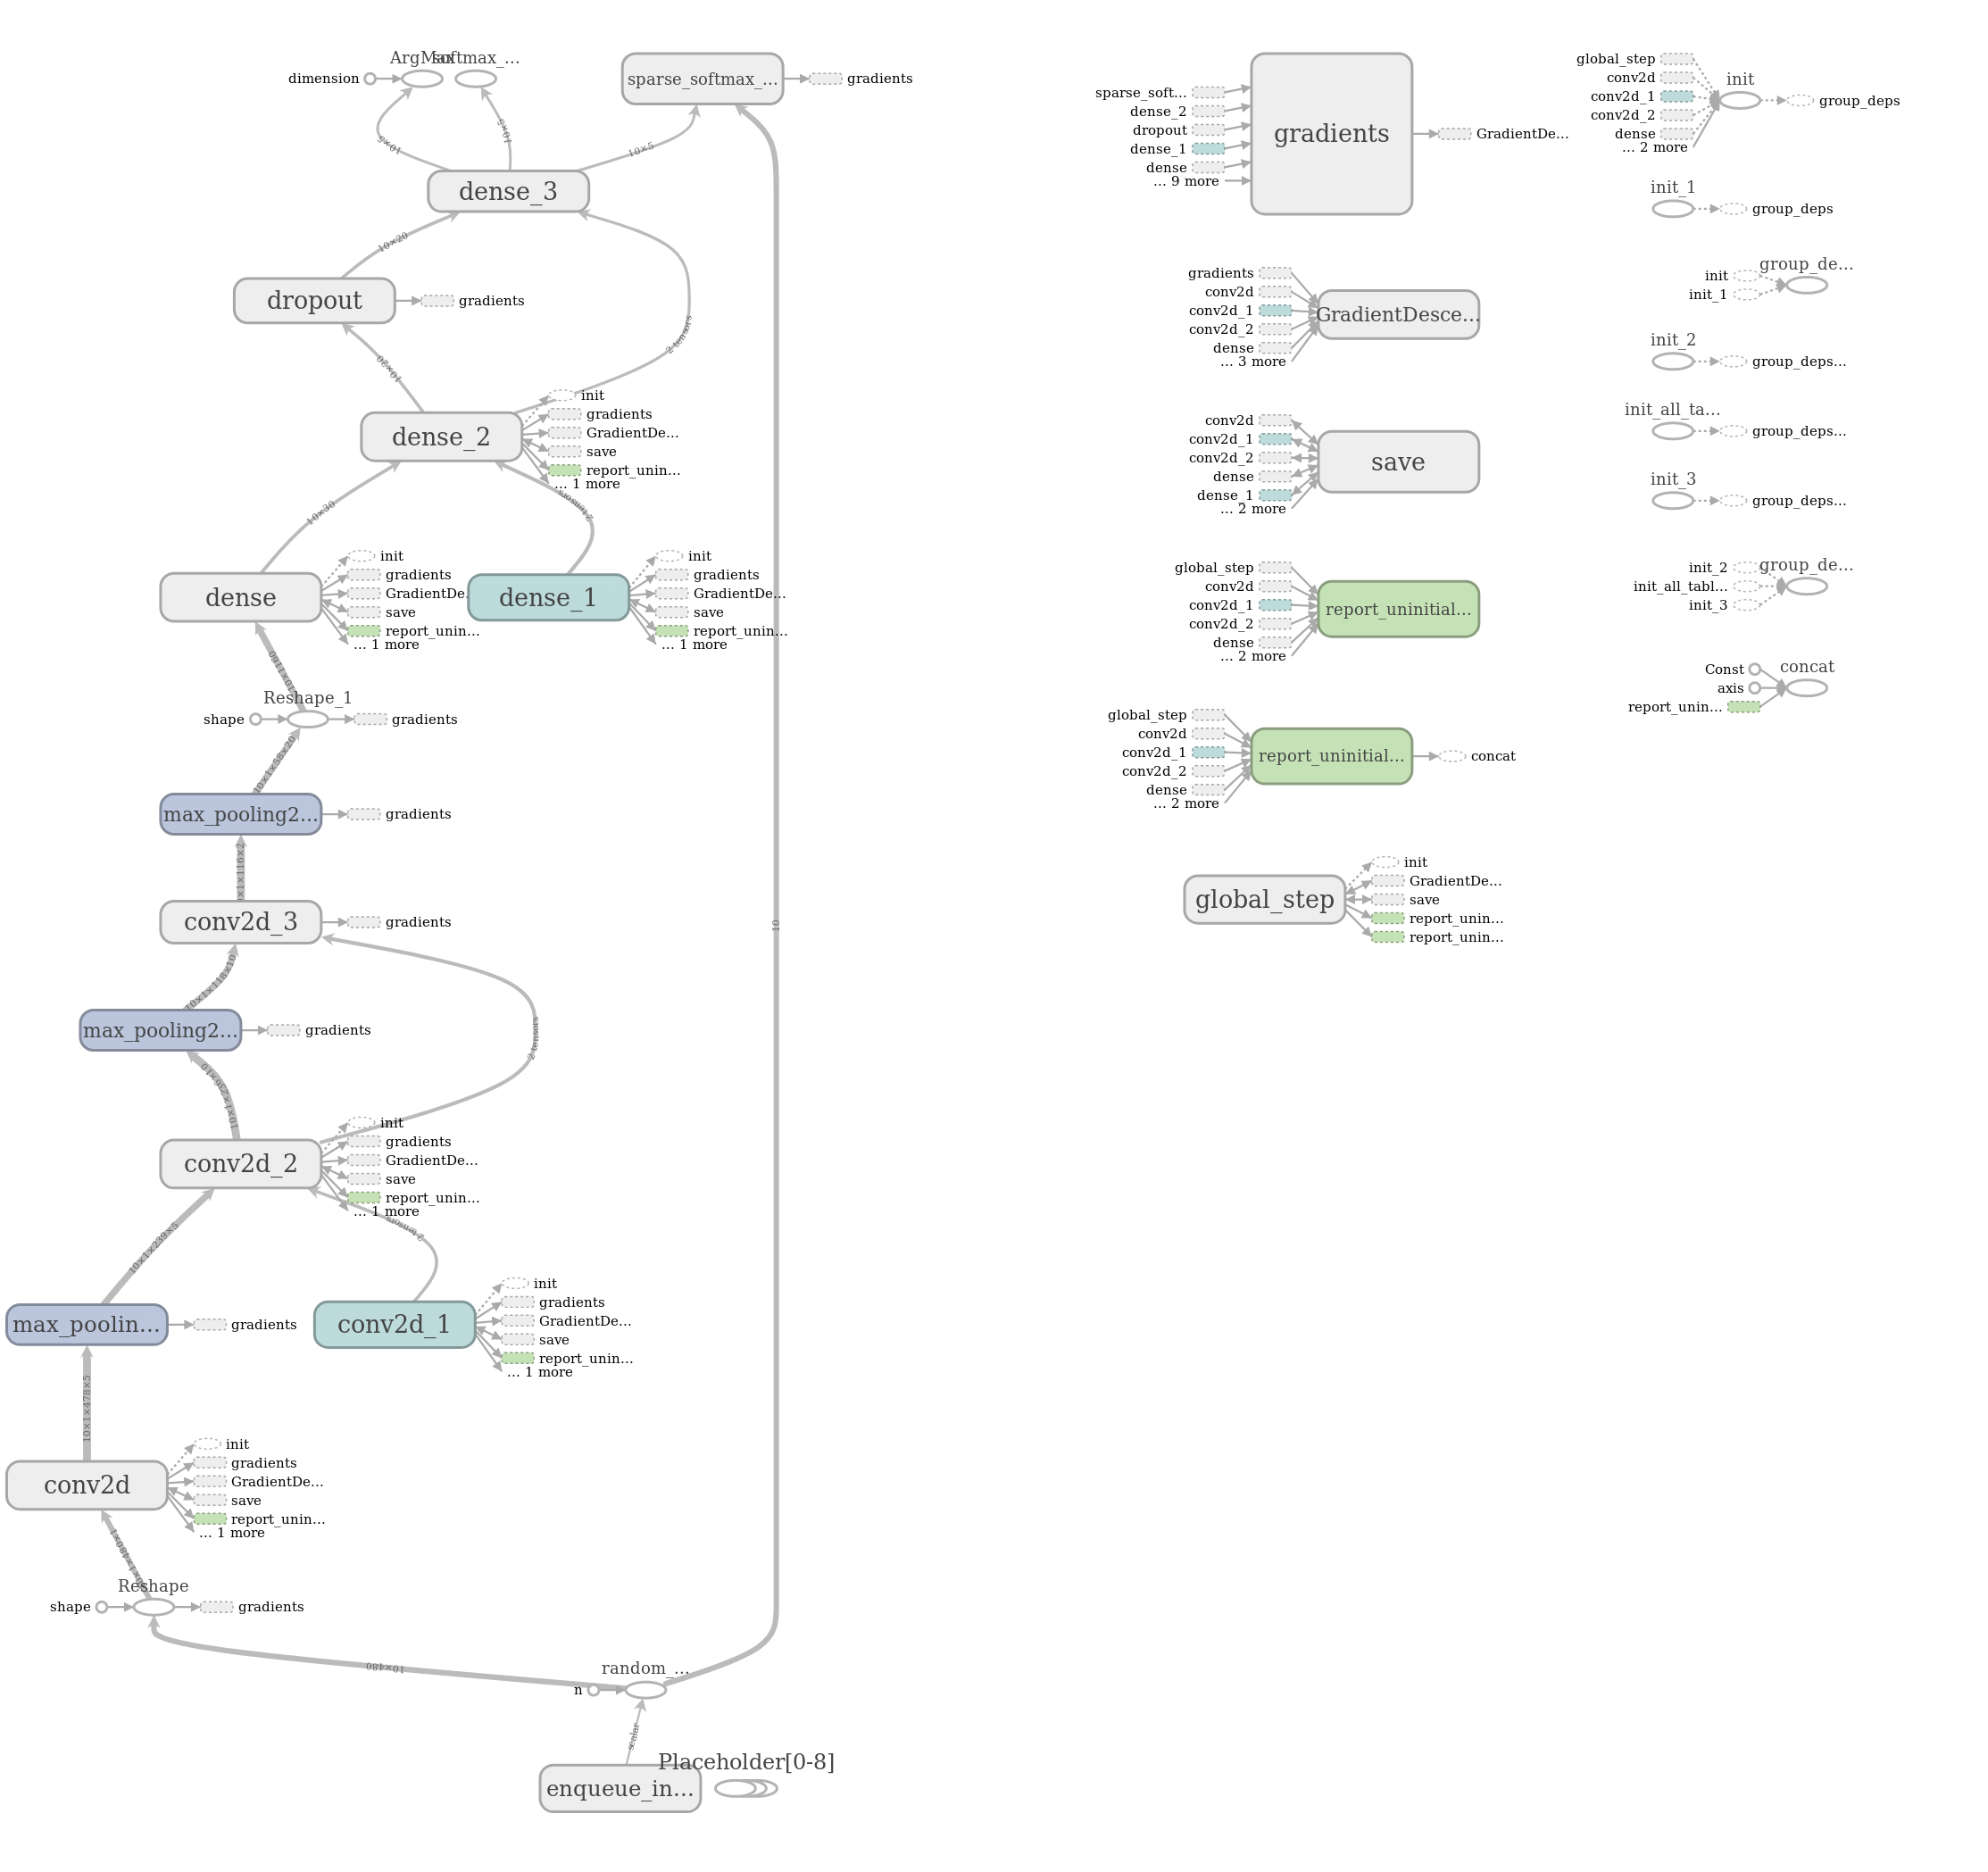

In [3]:
from IPython.display import Image
Image("img/cnn_v2.png")

##### Set up classifier and run the training of the network

In [ ]:
import tensorflow as tf

ecg_classifier = tf.estimator.Estimator(model_fn=cnn_v1.cnn_model_fn2, model_dir="/tmp/ecg_convnet_model2")
    
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)
    
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=10,
    num_epochs=None,
    shuffle=True)
ecg_classifier.train(
    input_fn=train_input_fn,
    steps=2000,
    hooks=[logging_hook])

##### Run evaluation of the model

In [ ]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=20,
    shuffle=False)
eval_results = ecg_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

##### Result

In [ ]:
{'accuracy': 0.91249186, 'loss': 0.48948607, 'global_step': 6440}

### 2b) Testing efficiency of data cleansing steps (Denoise + Baseline Wander removal)

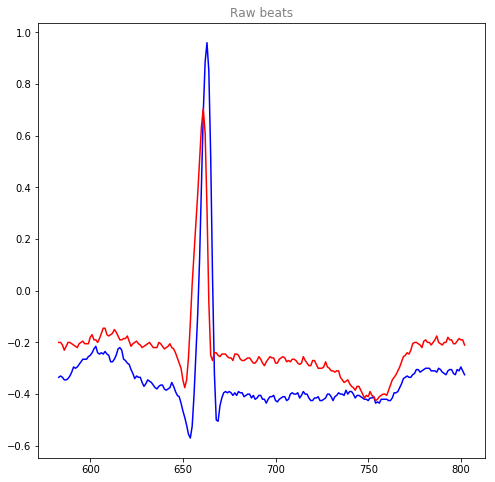

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

preX = 79;
postX = 140;
begNList = [];
endNList = [];
mixNList = [];
sliceNList = [];
    
for index, row in ds2_ann["100"].iterrows():
    Nbegin = row['sample'] - preX;
    Nend = row['sample'] + postX;
    begNList.append(Nbegin);
    endNList.append(Nend);

mixNList = tuple(zip(begNList,endNList)) 
#mixNList[-1]
        
plt.figure(figsize=(8,8))

for x in range(0,1):
    dfseg1 = ds2_all["100"][(ds2_all["100"]['sample'] >= mixNList[x][0]) & (ds2_all["100"]['sample'] <= mixNList[x][1])]
    plt.title('Raw beats', color="grey")
    plt.plot(dfseg1['MLII'], color="blue")
    plt.plot(dfseg1['V5'], color="red")

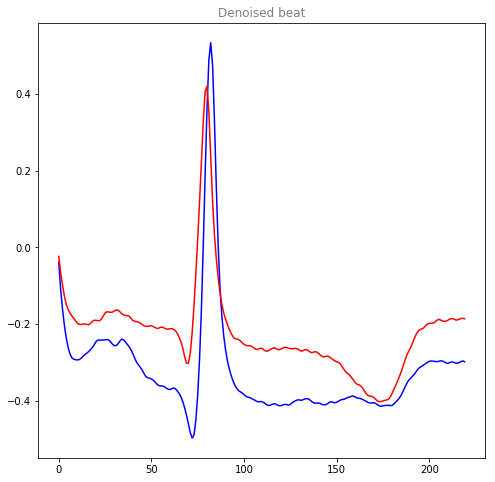

In [6]:
from scipy import signal

# Butterworth filter: x -> y
lowcut=0.01
highcut=15.0
signal_freq=360
filter_order=1
plt.figure(figsize=(10,10))
nyquist_freq = 0.5*signal_freq
low=lowcut/nyquist_freq
high=highcut/nyquist_freq

b, a = signal.butter(filter_order, [low,high], btype="band")


import matplotlib.pyplot as plt
%matplotlib inline

preX = 79;
postX = 140;
begNList = [];
endNList = [];
mixNList = [];
sliceNList = [];
    
for index, row in ds2_ann["100"].iterrows():
    Nbegin = row['sample'] - preX;
    Nend = row['sample'] + postX;
    begNList.append(Nbegin);
    endNList.append(Nend);

mixNList = tuple(zip(begNList,endNList)) 
#mixNList[-1]
        
plt.figure(figsize=(8,8))

for x in range(0,1):
    dfseg1 = ds2_all["100"][(ds2_all["100"]['sample'] >= mixNList[x][0]) & (ds2_all["100"]['sample'] <= mixNList[x][1])]
    y1 = signal.lfilter(b, a, dfseg1['MLII'])
    y2 = signal.lfilter(b, a, dfseg1['V5'])
    plt.title('Denoised beat', color="grey")
    plt.plot(y1, color="blue")
    plt.plot(y2, color="red")

In [37]:
import peakutils
import matplotlib.pyplot as plt
%matplotlib inline

# Prepare the input vectors as numpy arrays
train_data = ds1_seg
train_labels = np.asarray(ds1_lab, dtype=np.int32)
eval_data = ds2_seg
eval_labels = np.array(ds2_lab, dtype=np.int32)

baseline_values = peakutils.baseline(y1)

z = y1-baseline_values

ds1_all


{'101':         sample   MLII     V5
 0            0 -0.345 -0.160
 1            1 -0.345 -0.160
 2            2 -0.345 -0.160
 3            3 -0.345 -0.160
 4            4 -0.345 -0.160
 5            5 -0.345 -0.160
 6            6 -0.345 -0.160
 7            7 -0.345 -0.160
 8            8 -0.330 -0.150
 9            9 -0.320 -0.145
 10          10 -0.320 -0.170
 11          11 -0.325 -0.180
 12          12 -0.330 -0.170
 13          13 -0.325 -0.150
 14          14 -0.315 -0.160
 15          15 -0.305 -0.170
 16          16 -0.300 -0.185
 17          17 -0.315 -0.195
 18          18 -0.320 -0.185
 19          19 -0.315 -0.185
 20          20 -0.300 -0.175
 21          21 -0.290 -0.200
 22          22 -0.290 -0.190
 23          23 -0.295 -0.205
 24          24 -0.290 -0.195
 25          25 -0.295 -0.175
 26          26 -0.285 -0.175
 27          27 -0.255 -0.190
 28          28 -0.230 -0.200
 29          29 -0.200 -0.215
 ...        ...    ...    ...
 649970  649970 -0.285 -0.095
 64

##### Using the same network model as in 2), the achieved accuracy is:

In [ ]:
{'accuracy': 0.8903139, 'loss': 0.78278273, 'global_step': 8000}

In [2]:
# Set the length of the beat segment -> 40 ticks, appr. 1 QRS-interval
preX = 19
postX = 20
# Load DS1 - train and DS2 - eval datasets
ds1_all, ds1_ann, ds1_seg, ds1_lab = cnn_v1.create_DS("1",preX,postX)
#ds2_all, ds2_ann, ds2_seg, ds2_lab = cnn_v1.create_DS("2",preX,postX)

In [3]:
ds1_ann["101"]['RRI']

1       0.875000
2       0.891667
3       0.933333
4       0.955556
5       0.900000
6       0.869444
7       0.869444
8       0.861111
9       0.913889
10      0.916667
11      0.913889
12      0.897222
13      0.905556
14      0.886111
15      0.869444
16      0.911111
17      0.913889
18      0.902778
19      0.847222
20      0.838889
21      0.869444
22      0.888889
23      0.897222
24      0.886111
25      0.858333
26      0.852778
27      0.847222
28      0.819444
29      0.852778
30      0.902778
          ...   
1834    0.933333
1835    0.944444
1836    0.977778
1837    0.947222
1838    1.005556
1839    1.041667
1840    1.033333
1841    0.947222
1842    0.930556
1843    1.013889
1844    1.041667
1845    1.013889
1846    1.013889
1847    0.994444
1848    1.019444
1849    1.005556
1850    1.066667
1851    1.061111
1852    0.983333
1853    0.972222
1854    0.977778
1855    1.027778
1856    1.038889
1857    1.038889
1858    1.013889
1859    0.991667
1860    0.988889
1861    0.9916